# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
**Please make sure you have h5py and torchnet installed**
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master

## Known Windows Issues:
### In case you're getting an error [Read more](https://discuss.pytorch.org/t/brokenpipeerror-errno-32-broken-pipe-when-i-run-cifar10-tutorial-py/6224): 
```python
BrokenPipeError: [Errno 32] Broken pipe
```

>In the dataloader block change Line 39, 42, and 45 num_workers=0 

### In case of error (This should be a CUDA error [Read more](https://discuss.pytorch.org/t/asserterror-in-lstm-layer-on-gpu/8698)):

```python
--> 186             assert param_from.type() == param_to.type()
AssertionError: 
```

**Replace following lines:**
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence).type(FloatTensor)
    input_label_var = Variable(label).type(LongTensor)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence).type(FloatTensor)
    ...
```
** With: **
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence)
    input_label_var = Variable(label)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence)
    ...
```

In [1]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt


use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor



C:\environment\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


use cuda: True


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 4000 training sequences, 800 validation sequences, and 1000 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25).

For your convenience, we provide the dataloader for you.


In [2]:
from sklearn import preprocessing
def normalize(data):
    n,s,d = data.shape
    new_data = np.reshape(data,(n,s*d))
    scaler =  preprocessing.Normalizer()
    new_data = scaler.fit_transform(new_data)
    data = np.reshape(new_data,(n,s,d))
    return data,scaler

def normalize_trans(data,scaler=None):
    n,s,d = data.shape
    new_data = np.reshape(data,(n,s*d))
    new_data = scaler.transform(new_data)
    data = np.reshape(new_data,(n,s,d))
    return data

In [4]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train', scaler=None):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset
#         self.scaler = scaler
        '''
        if subset=='train':
            with h5py.File(self.data_path) as f:
                self.data,self.scaler = normalize(np.array(f['data']))
        else:
            with h5py.File(self.data_path) as f:
                self.data = normalize_trans(np.array(f['data']),scaler)
        '''
        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])
        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

trSet = Dataset('./data', subset='train')
valSet = Dataset('./data', subset='val')
tstSet = Dataset('./data', subset='test')

batch_size = 50
trLD = DD.DataLoader(trSet, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(trSet),
       num_workers=0, pin_memory=False)
valLD = DD.DataLoader(valSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(valSet),
       num_workers=0, pin_memory=False)
tstLD = DD.DataLoader(tstSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(tstSet),
       num_workers=0, pin_memory=False)

input_dim = trSet.n_dim
num_class = 10

In [12]:
trSet.data.shape

(4000, 15, 75)

In [67]:
trSet.data.min()

-0.5

In [48]:
trSet.data.max()

0.6915677

In [56]:
data = np.reshape(valSet.data,(800,15*75))

In [57]:
data[0]

array([ 0.01484092,  0.0968764 ,  0.1975097 , ..., -0.09356669,
        0.17099081,  0.19392389], dtype=float32)

In [58]:
data[1]

array([ 0.06214263,  0.11935428,  0.11998147, ..., -0.11136864,
        0.4681001 ,  0.10671961], dtype=float32)

In [59]:
data.mean(axis=0).max()

0.3046246

In [60]:
data.mean(axis=0).min()

-0.20413572

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* 1 Layer LSTM layer with hidden size of 100, and input size of 75
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



In [39]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (20 points) ##############
        ###################################################
        self.recurrent_layer = torch.nn.LSTM(input_size = 75,hidden_size = 100, num_layers = 2, dropout=0.5)
        self.classify_layer = torch.nn.Sequential(torch.nn.Conv1d(15,10,3),torch.nn.BatchNorm1d(10),torch.nn.ReLU(),torch.nn.Dropout(0.5),Flatten(),torch.nn.Linear(980,10))
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
#         logits = self.project_layer(rnn_outputs[:,-1])
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify().cuda()

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-2, and a cross-entropy loss function:

In [34]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [35]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
#         print(sequence.shape)
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var).cuda()      
        loss = criterion(output_logits, input_label_var).cuda()

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.data[0])
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)

    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return meter_loss.value()[0],acc.value()[0]


In [36]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

In [40]:
stage = 5
num_epochs = 100
evaluate_every_epoch = 5
lr_list = [0.01,0.008,0.006,0.004,0.002]
for s in range(stage):
    lr_ = lr_list[s]
    optimizer = torch.optim.SGD(model.parameters(), lr = lr_, momentum=0.9)
    for e in range(num_epochs):
        loss,acc = run_epoch(trLD, model, criterion, e, True, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        if (e+1) % evaluate_every_epoch == 0:
            loss,acc = run_epoch(valLD, model, criterion, e, False, None)   
            valid_loss.append(loss)
            valid_acc.append(acc)

C:\environment\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Epoch: 0  , Loss: 2.4045,  Accuracy: 9.33
train Epoch: 1  , Loss: 2.3535,  Accuracy: 9.70
train Epoch: 2  , Loss: 2.3350,  Accuracy: 9.80
train Epoch: 3  , Loss: 2.3331,  Accuracy: 10.00
train Epoch: 4  , Loss: 2.3320,  Accuracy: 9.95
val Epoch: 4  , Loss: 2.4439,  Accuracy: 13.88
train Epoch: 5  , Loss: 2.3311,  Accuracy: 9.90
train Epoch: 6  , Loss: 2.3299,  Accuracy: 10.38
train Epoch: 7  , Loss: 2.3243,  Accuracy: 11.52
train Epoch: 8  , Loss: 2.2794,  Accuracy: 14.00
train Epoch: 9  , Loss: 2.0370,  Accuracy: 22.90
val Epoch: 9  , Loss: 1.9220,  Accuracy: 31.75
train Epoch: 10  , Loss: 1.7838,  Accuracy: 32.73
train Epoch: 11  , Loss: 1.6422,  Accuracy: 39.58
train Epoch: 12  , Loss: 1.5531,  Accuracy: 43.03
train Epoch: 13  , Loss: 1.5020,  Accuracy: 44.65
train Epoch: 14  , Loss: 1.4033,  Accuracy: 48.95
val Epoch: 14  , Loss: 1.1479,  Accuracy: 61.62
train Epoch: 15  , Loss: 1.3212,  Accuracy: 51.60
train Epoch: 16  , Loss: 1.2416,  Accuracy: 54.90
train Epoch: 17  , Loss

train Epoch: 39  , Loss: 0.5295,  Accuracy: 81.40
val Epoch: 39  , Loss: 0.7508,  Accuracy: 78.50
train Epoch: 40  , Loss: 0.5260,  Accuracy: 80.92
train Epoch: 41  , Loss: 0.5431,  Accuracy: 80.75
train Epoch: 42  , Loss: 0.5401,  Accuracy: 80.50
train Epoch: 43  , Loss: 0.5421,  Accuracy: 80.88
train Epoch: 44  , Loss: 0.5379,  Accuracy: 80.30
val Epoch: 44  , Loss: 0.7302,  Accuracy: 78.38
train Epoch: 45  , Loss: 0.5584,  Accuracy: 79.97
train Epoch: 46  , Loss: 0.5481,  Accuracy: 80.33
train Epoch: 47  , Loss: 0.5519,  Accuracy: 80.80
train Epoch: 48  , Loss: 0.5081,  Accuracy: 82.27
train Epoch: 49  , Loss: 0.5252,  Accuracy: 81.25
val Epoch: 49  , Loss: 0.7415,  Accuracy: 77.25
train Epoch: 50  , Loss: 0.5398,  Accuracy: 80.70
train Epoch: 51  , Loss: 0.5305,  Accuracy: 80.67
train Epoch: 52  , Loss: 0.5036,  Accuracy: 81.70
train Epoch: 53  , Loss: 0.5041,  Accuracy: 81.77
train Epoch: 54  , Loss: 0.5416,  Accuracy: 80.03
val Epoch: 54  , Loss: 0.7038,  Accuracy: 79.12
train Ep

train Epoch: 77  , Loss: 0.4110,  Accuracy: 84.80
train Epoch: 78  , Loss: 0.3915,  Accuracy: 86.00
train Epoch: 79  , Loss: 0.4158,  Accuracy: 85.25
val Epoch: 79  , Loss: 0.7041,  Accuracy: 81.00
train Epoch: 80  , Loss: 0.4007,  Accuracy: 86.02
train Epoch: 81  , Loss: 0.4237,  Accuracy: 84.53
train Epoch: 82  , Loss: 0.4056,  Accuracy: 84.97
train Epoch: 83  , Loss: 0.4110,  Accuracy: 85.28
train Epoch: 84  , Loss: 0.4001,  Accuracy: 85.53
val Epoch: 84  , Loss: 0.6824,  Accuracy: 80.88
train Epoch: 85  , Loss: 0.3945,  Accuracy: 85.97
train Epoch: 86  , Loss: 0.3976,  Accuracy: 85.58
train Epoch: 87  , Loss: 0.4235,  Accuracy: 85.10
train Epoch: 88  , Loss: 0.3914,  Accuracy: 86.02
train Epoch: 89  , Loss: 0.4262,  Accuracy: 84.62
val Epoch: 89  , Loss: 0.6807,  Accuracy: 81.50
train Epoch: 90  , Loss: 0.4017,  Accuracy: 85.50
train Epoch: 91  , Loss: 0.4017,  Accuracy: 85.55
train Epoch: 92  , Loss: 0.3956,  Accuracy: 85.82
train Epoch: 93  , Loss: 0.3952,  Accuracy: 85.53
train 

train Epoch: 15  , Loss: 0.3191,  Accuracy: 88.42
train Epoch: 16  , Loss: 0.3200,  Accuracy: 88.72
train Epoch: 17  , Loss: 0.3096,  Accuracy: 89.30
train Epoch: 18  , Loss: 0.3105,  Accuracy: 88.92
train Epoch: 19  , Loss: 0.3177,  Accuracy: 88.67
val Epoch: 19  , Loss: 0.7062,  Accuracy: 81.25
train Epoch: 20  , Loss: 0.2935,  Accuracy: 89.30
train Epoch: 21  , Loss: 0.3097,  Accuracy: 88.78
train Epoch: 22  , Loss: 0.3033,  Accuracy: 88.88
train Epoch: 23  , Loss: 0.3122,  Accuracy: 88.42
train Epoch: 24  , Loss: 0.3077,  Accuracy: 88.92
val Epoch: 24  , Loss: 0.6756,  Accuracy: 81.25
train Epoch: 25  , Loss: 0.3265,  Accuracy: 88.60
train Epoch: 26  , Loss: 0.2969,  Accuracy: 89.58
train Epoch: 27  , Loss: 0.3102,  Accuracy: 88.52
train Epoch: 28  , Loss: 0.2896,  Accuracy: 89.60
train Epoch: 29  , Loss: 0.3192,  Accuracy: 88.28
val Epoch: 29  , Loss: 0.6653,  Accuracy: 82.50
train Epoch: 30  , Loss: 0.3257,  Accuracy: 88.50
train Epoch: 31  , Loss: 0.3011,  Accuracy: 89.30
train 

In [48]:
len(train_loss[258:])
len()

500

In [51]:
len(valid_loss[51:])

100

In [52]:
train_loss = train_loss[258:]
valid_loss = valid_loss[51:]
train_acc = train_acc[258:]
valid_acc = valid_acc[51:]

In [56]:
len(train_acc)

500

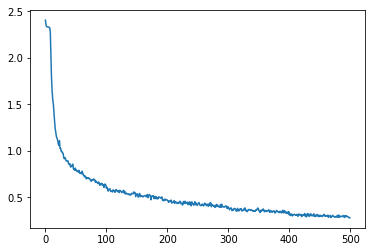

In [46]:
plt.plot(train_loss[258:])
plt.show()

## Submit your results on Kaggle

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set.


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw5) to see how well your network performs on the test set. 
################ 3rd To Do  (30 points, the highest 3 entries get extra 10 points) ###############


In [41]:
# Use your best model to generate results on test set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i].item())+'\n')
            count+=1
    results.close()
    return count

count=predict_on_test(model, tstLD)
print(count)

1000


## Report the performance
################ 4th To Do  (15 points)##################

### Documentation of what you did
In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epoches) and visualizations or graphs of loss/accuracy curve tin the process of training and evaluating.

#### preprocess:
standlization with sklearn

#### architecture:
2 layer LSTM + CNN + BatchNorm + ReLU + Dropout + Flatten() + Linear.

self.recurrent_layer = torch.nn.LSTM(input_size = 75,hidden_size = 100, num_layers = 2, dropout=0.5)
        
self.classify_layer = torch.nn.Sequential(torch.nn.Conv1d(15,10,3),torch.nn.BatchNorm1d(10),torch.nn.ReLU(),torch.nn.Dropout(0.5),Flatten(),torch.nn.Linear(980,10))
        

#### optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

#### learning rate
lr_list = [0.01,0.008,0.006,0.004,0.002] 
for epoch = 0-200,200-400,400-600,600-800,800-10000
#### epoches = 1000

#### Visualize

In [42]:
from matplotlib import pyplot as plt

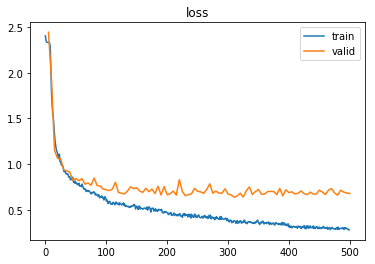

In [53]:
valid_epoch = [x+5 for x in range(0,500,5)]
train_epoch = [x for x in range(500)]
plt.plot(train_epoch,train_loss,label='train')
plt.plot(valid_epoch,valid_loss,label='valid')
plt.title("loss")
plt.legend()
plt.show()

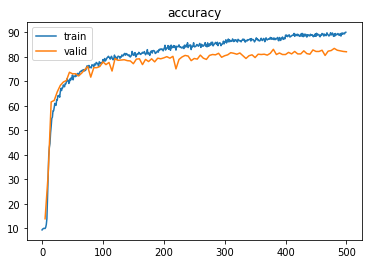

In [57]:
valid_epoch = [x+5 for x in range(0,500,5)]
train_epoch = [x for x in range(500)]
plt.plot(train_epoch,train_acc,label='train')
plt.plot(valid_epoch,valid_acc,label='valid')
plt.title("accuracy")
plt.legend()
plt.show()

### performance on Kaggle
You should also report your Kaggle Performance here:

score: 82.1%